<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P4.2_Graph_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P4.2: Graph Classification (using Graph Neural Networks)
In this practical we will apply Graph Neural Networks (GNNs) to the task of
classifying entire graphs. We will use PyTorch and the PyTorch Geometric library
[[1]](#pytorchgeomintro).

Upon completing this practical, you will have:

*   Studied a hands-on introduction to the graph classification problem;
*   Enhanced your understanding of Graph Neural Networks by implementing a
    message passing GNN (as described in the lecture notes) from scratch in
    PyTorch;
*   Learned how to use the PyTorch Geometric library for minibatching graphs.


# Preparation
To start, we install the packages we need, set up some formatting for the
notebook, and download the data we use in this practical. If necessary,
uncomment and run the cell below to install the required packages (for example
if you're using google colab).

In [191]:
# PyTorch Geometric is not part of the standard Colab packages; we must
# install it ourselves.
# !pip install torch_geometric

# PyTorch Geometric version 2.5.2 should work with PyTorch version
# 2.2.1. If the Colab environment by now has a later version of PyTorch
# installed and if that does not yet work with PyTorch Geometric, you
# can install specific versions of torch and torch_geometric by using
# the commands below instead of the one above. This might take a few
# minutes.
# !pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 torchaudio==2.2.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121
# !pip install torch_geometric==2.5.2

# Optional dependencies:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

In [192]:
# # We want to limit the height of the output cells.
from IPython.display import HTML, display, Javascript
import time

In [193]:
# We will use the Mutagenicity dataset, which is part of the standard
# datasets in torch geometric. downloading may take some time
from torch_geometric.datasets import TUDataset
import numpy as np
dataset = TUDataset(root='data/mutagen', name='Mutagenicity', use_node_attr=True, use_edge_attr=False)

In [194]:
# the below list and dict maps an integer to the corresponiding element
# string and an element string to a color respectively. this will be
# useful for plotting molecules later on

element_map = ['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
element_color = {
    'H': [1.0, 1.0, 1.0],
 'Li': [0.8, 0.5019607843137255, 1.0],
 'C': [0.5647058823529412, 0.5647058823529412, 0.5647058823529412],
 'N': [0.18823529411764706, 0.3137254901960784, 0.9725490196078431],
 'O': [1.0, 0.050980392156862744, 0.050980392156862744],
 'F': [0.5647058823529412, 0.8784313725490196, 0.3137254901960784],
 'Na': [0.6705882352941176, 0.3607843137254902, 0.9490196078431372],
 'P': [1.0, 0.5019607843137255, 0.0],
 'S': [1.0, 1.0, 0.18823529411764706],
 'Cl': [0.12156862745098039, 0.9411764705882353, 0.12156862745098039],
 'K': [0.5607843137254902, 0.25098039215686274, 0.8313725490196079],
 'Ca': [0.23921568627450981, 1.0, 0.0],
'Br': [0.6509803921568628, 0.1607843137254902, 0.1607843137254902],
 'I': [0.5803921568627451, 0.0, 0.5803921568627451]}

# Problem Formulation
The type of data we consider is graph data, where a graph is defined by its
nodes and edges, $\mathcal{G} = (\mathcal{V},\mathcal{E})$. The dataset consists
of many (comparatively small) graphs, and we seek to classify these graphs in
their entirety. As such, in this practical, a *graph* is analogous to an image
in an image classification task (as opposed to the earlier tutorial, where we
tried to classify each *node* in a graph).

We can define our data $X$ as a set of graphs, i.e., $X = \{\mathcal{G}_0,
\mathcal{G}_1, \ldots, \mathcal{G}_n\}$, wich corresponding labels $\{Y_0, Y_1,
\ldots, Y_n\}$.

## Dataset: Database of molecules and their mutagenicity
The dataset we look at for this practical consists of molecules and their
mutagenicity property[[2]](#mutagenicity). This property describes whether a
molecule can induce genetic mutations or not, making it a binary attribute. 

The datapoints in the dataset are molecular graphs $\mathcal{G}_i \in X$, and
each such molecule-graph is assigned a label 0 (no mutagenicity) or 1
(mutagenicity). The nodes in the molecule-graph indicate (chemical) elements,
whereas edges indicate connections between these elements.

We want to train a GNN to take these graphs as input and output a prediction.
Note that there are no constraints on these graphs in terms of size or
connections, so our model must be able to process arbitrary graphs. This is
where the use of GNNs shines, as this class of NN-models can process graphs of
arbitrary shape.

Next, we will further examine our dataset and split it into a train and
validation set. Note that for this practical, we don't use a test set.

In [195]:
print(f'Number of examples: {len(dataset)}')
print('')
print("Let's print a few examples' shape:")
for i in range(4):
    print(dataset[i])

Number of examples: 4337

Let's print a few examples' shape:
Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Data(edge_index=[2, 154], x=[72, 14], edge_attr=[154, 3], y=[1])
Data(edge_index=[2, 26], x=[14, 14], edge_attr=[26, 3], y=[1])
Data(edge_index=[2, 76], x=[36, 14], edge_attr=[76, 3], y=[1])


The dataset consists of 4337 molecules. As we can see from printing a few
examples, they vary in shape. As a reminder of what these tensors are, for an
arbitrary graph $\mathcal{G}$:

$edge\_attr=[\mathcal{G}_\mathcal{E}, \mathcal{E}_a]$: edge attributes. For each
edge $\mathcal{E}$ in graph $\mathcal{G}$, we have $\mathcal{E}_a$ attributes.
For simplicity, we do not use these attributes in this notebook, but once you
have a GNN architecture set up, it should be straightforward to incorporate edge
features as well.

$edge\_index=[2, \mathcal{G}_\mathcal{E}]$: the tensor describing all edges in
the graph. The first row describes the source node of each edge and the second
row describes the target node of each edge. E.g., $edge\_index=[[0, 1, 2], [3,
4, 5]]$ describes edges $(0, 3), (1, 4)$ and $(2, 5)$. For undirected graphs (as
in this practical), we assume that the edge index contains both $(i ,j)$ and
$(j,i)$ for all connected nodes $i, j$.

$x=[\mathcal{G}_\mathcal{V}, \mathcal{V}_a]$: the tensor describing all nodes
and their attributes. For each node $\mathcal{V}$ in graph $\mathcal{G}$, we
have $\mathcal{V}_a$ attributes.

$y=[1]$: The (binary) label for the graph.

The number of nodes and edges ($\mathcal{G}_\mathcal{V}$ and
$\mathcal{G}_\mathcal{E}$) can differ for each graph, whereas the node and edge
attributes ($\mathcal{V}_a$ and $\mathcal{E}_a$) are fixed for the entire
dataset. As stated before, we do not use the edge attributes in this practical.
The node attributes *are* used. Each node has a one-hot vector that indicates
what element the node is. The following 14 elements are used in this dataset:
```
['C', 'O', 'Cl', 'H', 'N', 'F', 'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
```
For each node, the attribute is a one-hot encoding with the index of the 1
indicating what element it is, according to the list printed above.

We aim to use these node attributes ($x$) along with their connections
($edge\_index$) to predict the mutagenicity of the molecule ($y$). To get an
idea of what a single datapoint looks like, we define a function to draw one.

In [196]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def draw_molecule(graph, title=''):
    plt.figure(figsize=(10, 5))
    nodes = {}  # create a node dict (idx:element) to create a nx graph
    for i in range(graph.x.shape[0]):
        element_idx = np.argmax(graph.x[i])
        nodes[i] = element_map[element_idx]
    edges = []  # create an edge list for the nx graph
    for i in range(graph.edge_index.shape[1]):
        s, t = graph.edge_index[:, [i]]
        s, t = int(s), int(t)
        edges.append((s, t))

    g = nx.Graph()  # create a graph
    g.add_nodes_from(nodes)
    g.add_edges_from(edges) 
    
    pos = nx.planar_layout(g)  # the graph has no 'position': generate a node-layout
    pos = nx.spring_layout(g, pos=pos)

    colors = [element_color[i] for _, i in nodes.items()]  # set the color for each node
    nx.draw(g, pos=pos, labels=nodes, node_color=colors, width=1)  # and draw the graph
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")  # color the edges
    
    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))  # center the image
    
    plt.title(title)
    plt.show()

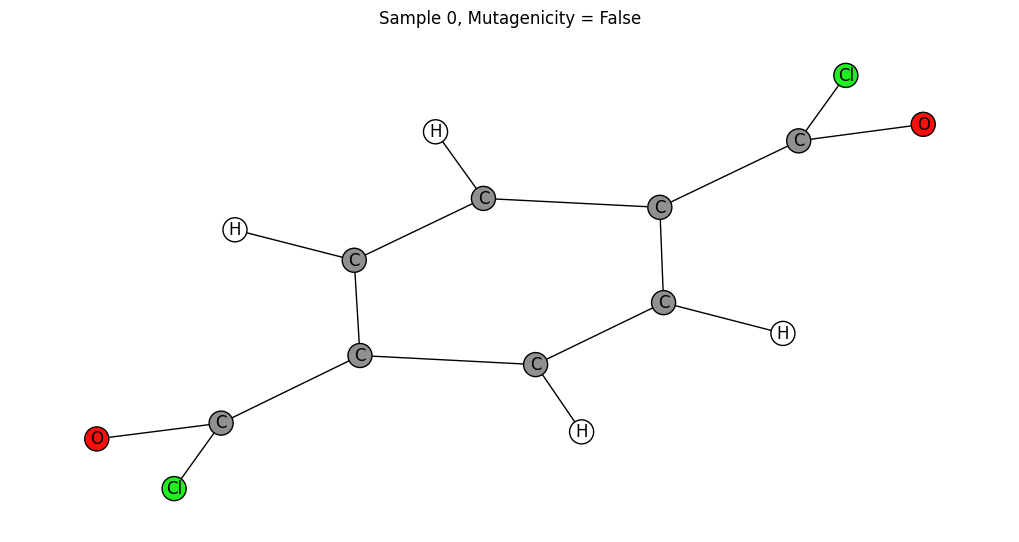

In [197]:
idx = 0
draw_molecule(dataset[idx], f'Sample {idx}, Mutagenicity = {bool(dataset[idx].y)}')

Note that the location/layout of the nodes is somewhat arbitrary and is
generated by our drawing function. The graph information we have only considers
the nodes' element, alongside what other nodes they are connected to. There are
no 'coordinates' available.

Next, we will split our dataset into a train and validation set and define a
dataloader. The latter allows us to process graphs in minibatches.

In [198]:
'''
We simply shuffle and split the dataset to create a train and validation
set.
'''
dataset.shuffle() # first, shuffle our dataset
train_idx = round(len(dataset) * 0.8) # 80:20 for the train:validation split
dataset_train = dataset[:train_idx]
dataset_val = dataset[train_idx:]

In [199]:
'''
To process the dataset in minibatches, we use a DataLoader object. All
we must do is supply the data and set the batch_size, PyTorch Geometric
will take care of the rest. Note that the batch_size indicates the
number of graphs in a batch, not the number of nodes.
'''
from torch_geometric.loader import DataLoader

batch_size = 256
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [200]:
# To understand how graphs are batched, print one
for data in train_loader:
    print(data)
    break

DataBatch(edge_index=[2, 15938], x=[7833, 14], edge_attr=[15938, 3], y=[256], batch=[7833], ptr=[257])


Minibatching with graphs is slightly trickier than with structured inputs, as
each graph consists of different amounts of nodes and edges and PyTorch
requires all tensors in the batch to be of the same size. In short, to
efficiently process all nodes in a batch, PyTorch Geometric concatenates all
node/edge data for all graphs in the batch to a single graph object, where each
individual graph is a disconnected component (which explains the singular and
large $x$/$edge\_index$, etc). In computer memory, this graph is represented as
a single tensor, allowing more efficient processing on the GPU. To be able to
identify to which individual graph a node belongs, a $batch$ tensor maps each
node to the graph it belongs to. For more information, we refer to the
[documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches).

# TODO: Implement Graph Classification Model
Now that we have discussed the problem and dataset, we can move towards a
solution to the problem. Although PyTorch Geometric already implements many
common GNN architectures, the goal of this practical is to deepen your
understanding by implementing a GNN from scratch in PyTorch. This will also help
you in assignments or future projects where off-the-shelf GNN architectures may
be suboptimal.

In the below cells, we provide some imports that will come in handy, as well as
a few skeleton classes that can help you to structure your implementation.

An accuracy of 75-80% on the validation set should be achievable with a
relatively simple network (not too many layers) and without too much parameter
tuning, within 100 training epochs. Depending on your implementation, you can
expect the training of the model to take at most 10 minutes.


In [201]:
num_features = int(dataset_train[0].x.shape[1])
num_classes = int(max([d.y for d in dataset_train])+1)
import torch
import torch.nn as nn

In [202]:
"""
TODO: Implement a message passing GNN. Hint: you might want to look into
torch.Tensor.scatter_add_() or similar functions for aggregating tensors
at specified indices.
"""

class Node_to_emb(nn.Module):  # transforms input nodes to an embedding (similar to word embedding in NLP)
    def __init__(self, num_features: int, embedding_dim: int):
        super().__init__()
        #  TODO: initialize the layers you want to use in this class.
        self.embedding_dim = embedding_dim
        self.fc = nn.Linear(num_features, embedding_dim)

    def forward(self, nodes):
        #  TODO: call the layers in the forward pass.
        return self.fc(nodes) 
    
    
class MpLayer(torch.nn.Module):  # a neural message passing layer
    def __init__(self, hidden_dim: int, activation: nn.Module):
        super().__init__()
        
        self.aggregator_fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            # nn.Linear(hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation,
        )
        self.next_state_fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
        )
        
    def forward(self, input_to_layer):
        #  TODO: call the layers in the forward pass. Be sure to use an aggregation function that is invariant to permutations
        #        (such as summation, maximum, ...). Return the node embeddings after this message passing iteration.
        
        # Hint: the input_to_layer should consist of the node feature tensors and edge index tensors:
        node_tensor, edge_idx_tensor = input_to_layer

        # messages = self.aggregator_fc(node_tensor) # nodes x hidden_dim
        # messages = messages[edge_idx_tensor[0]] # edges x hidden_dim
        messages = self.aggregator_fc(torch.cat(
            [node_tensor[edge_idx_tensor[0, :]], node_tensor[edge_idx_tensor[1, :]]], dim=-1)) # nodes x hidden_dim
        
        aggregated_messages = torch.zeros_like(node_tensor) # nodes x hidden_dim
        index = edge_idx_tensor[1].unsqueeze(-1).expand(-1, aggregated_messages.size(1))
        # aggregated_messages = aggregated_messages.scatter_reduce_(dim=0, src=messages, index=index, reduce='sum')
        aggregated_messages = aggregated_messages.scatter_add_(dim=0, src=messages, index=index)

        next_state =  self.next_state_fc(torch.cat([node_tensor, aggregated_messages], dim=-1))
        return next_state, edge_idx_tensor
        

class MpGNN(torch.nn.Module): # a message passing GNN
    def __init__(self, num_passes: int, num_classes: int, num_features: int, hidden_dim: int, activation: nn.Module):
        super().__init__()
        #  TODO: initialize the layers you want to use in this class.
        
        #  Hint: the MpGNN must embed the categorical node features, apply message passing layers,
        #        and finally predict the mutagenicity of each graph in the batch.
        self.embedding_net = Node_to_emb(num_features, hidden_dim)
        self.forward_net = nn.Sequential(*[MpLayer(hidden_dim, activation) for _ in range(num_passes)])
        self.to_pred = nn.Sequential(nn.Linear(hidden_dim, num_classes), nn.Softmax())
        
    def forward(self, x, edge_index, batch):
        #  TODO: call the layers on a batch of input graphs in the forward pass,
        #        and return the model classification of each graph in the batch.
        
        # Hint: x is the tensor with node features, edge_index is the tensor with edge indices,
        #       and batch is the tensor containing the index of the graph in the batch that each node belongs to.

        x = self.embedding_net(x)

        input_model = (x, edge_index)
        output_model = self.forward_net(input_model)
        x,_ = output_model
        
        out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))
        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch
        
        return self.to_pred(out)
        
        

In [203]:
'''
Hint: you might want to try running on the cpu first for easier
debugging. Additionally, depending on your implementation, the GPU may
not even be faster than the CPU. (note that the focus of this assignment
is not the efficiency of the implementation on the GPU).
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [204]:
'''
TODO: Train the GNN. Complement the code where applicable (indicated
with #  TODO)
'''
model = MpGNN(5, num_classes, num_features, 32, nn.ReLU()) #  TODO: initialize our GNN
model.to(device)  # and move to the GPU, if possible

optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()


def train():  #  TODO: fill in the missing parts of this function below
    
    model.train()  # set the model to training mode
    
    for data in train_loader:  # loop through the training set in a batch-wise fashion
        
        data.to(device)  # move the batch to the device (GPU if applicable)
        optimizer.zero_grad()  # set gradients to 0
        
        out = model(data.x, data.edge_index, data.batch)  # propagate the data through the model
        gt = torch.zeros(data.y.size(0), 2).to(device)
        gt[:, 0] += data.y == 0
        gt[:, 1] += data.y == 1
        loss = loss_func(out, gt)
        
        loss.backward()  # derive gradients
        optimizer.step()  # update all parameters based on the gradients


        
def test(loader):  #  TODO: complete the code fo the test function (it should be similar to the train function)
    model.eval()  # set the model to evaluation mode
    
    correct = 0  # keep track of how many we have correct
    total = 0  # and how many we handle in total
    
    for data in loader:  # loop through the supplied dataset in a batch-wise fashion
        data.to(device)  # transfer batch to device
        
        out = model(data.x, data.edge_index, data.batch)  #  TODO: propagate the data through the model
        pred = out.argmax(dim=-1)
                
        correct += int((pred == data.y).sum())  # add the number of correct predictions
        total += len(data.y)  # and add the total number of elements
        
    return correct / total  # return the accuracy



# the below code is already complete and calls the train and test functions, and prints some statistics
train_accs = []
val_accs = []
epochs = 100
start = time.time()
for epoch in range(1, epochs+1):  # train for number of epochs
    
    train()  # do one training step over the entire dataset
    
    with torch.no_grad():
        train_acc = test(train_loader)  # compute the training accuracy
        val_acc = test(val_loader)  # compute the validation accuracy
    
    tic = time.time()
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}. Training time so far: {tic-start:.1f} s')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    val_accs.append(val_acc)
    

Epoch: 001, Train Acc: 0.5646, Validation Acc: 0.5536. Training time so far: 2.1 s
Epoch: 002, Train Acc: 0.5700, Validation Acc: 0.5571. Training time so far: 4.0 s
Epoch: 003, Train Acc: 0.6452, Validation Acc: 0.6251. Training time so far: 5.9 s
Epoch: 004, Train Acc: 0.5663, Validation Acc: 0.5513. Training time so far: 7.7 s
Epoch: 005, Train Acc: 0.6424, Validation Acc: 0.6332. Training time so far: 9.6 s
Epoch: 006, Train Acc: 0.6622, Validation Acc: 0.6378. Training time so far: 11.5 s
Epoch: 007, Train Acc: 0.6744, Validation Acc: 0.6471. Training time so far: 13.4 s
Epoch: 008, Train Acc: 0.6934, Validation Acc: 0.6759. Training time so far: 15.2 s
Epoch: 009, Train Acc: 0.6942, Validation Acc: 0.6817. Training time so far: 17.1 s
Epoch: 010, Train Acc: 0.7236, Validation Acc: 0.7174. Training time so far: 19.0 s
Epoch: 011, Train Acc: 0.7043, Validation Acc: 0.6886. Training time so far: 20.9 s
Epoch: 012, Train Acc: 0.7233, Validation Acc: 0.7290. Training time so far: 22.8

In [205]:
'''
To get an overview of the accuracy over the training period, we define a
simple function to plot the saved accuracies.
'''
def plot_train(train_accs, val_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(val_accs, color='red', linestyle='--', label='Validation')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

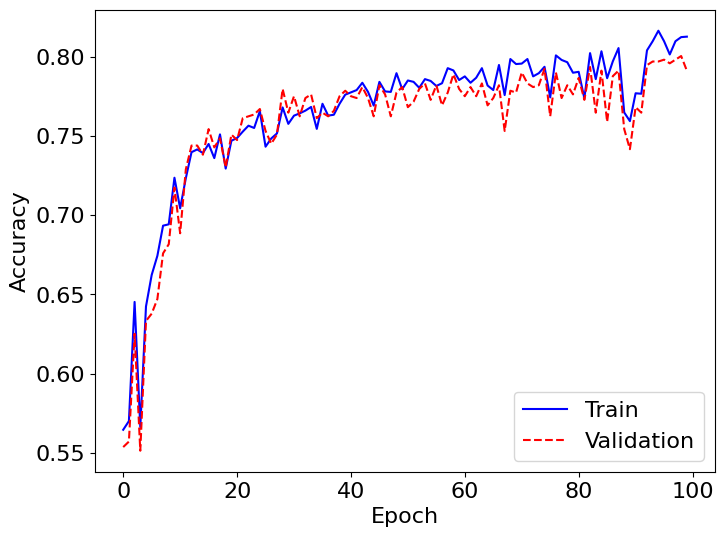

In [206]:
plot_train(train_accs, val_accs)

# Evaluation and discussion

To conclude, we shortly evaluate the performance of our model, and use it to
make predictions. We define a simple function for testing and drawing a single
molecule (from the validation set).

In [207]:
print(f'Final validation accuracy: {val_accs[-1]}')

Final validation accuracy: 0.7912341407151096


In [208]:
def test_sample(idx):
    mol = dataset_val[idx]  # take our sample
    mol.to(device)  # put it on device
    pred = model(mol.x,  # propagate nodes
                 mol.edge_index,   #  edges
                 torch.zeros(mol.x.shape[0], dtype=torch.long).to(device))  # 'batch' object of 0s (the one graph in the batch)

    pred = pred.to('cpu')  # put data back on cpu
    mol = mol.to('cpu')
    pred = int(pred.argmax(dim=1))  # gather predictions
    true = int(mol.y)  
    outcome = ['No mutagenicity', 'Mutagenicity']
    outcome_text = 'Predicted = "{}", Ground-truth = "{}"'.format(outcome[pred], outcome[true])  # create outcome text
    draw_molecule(mol, title=f'Sample {idx}\n' + outcome_text)  # draw the prediction

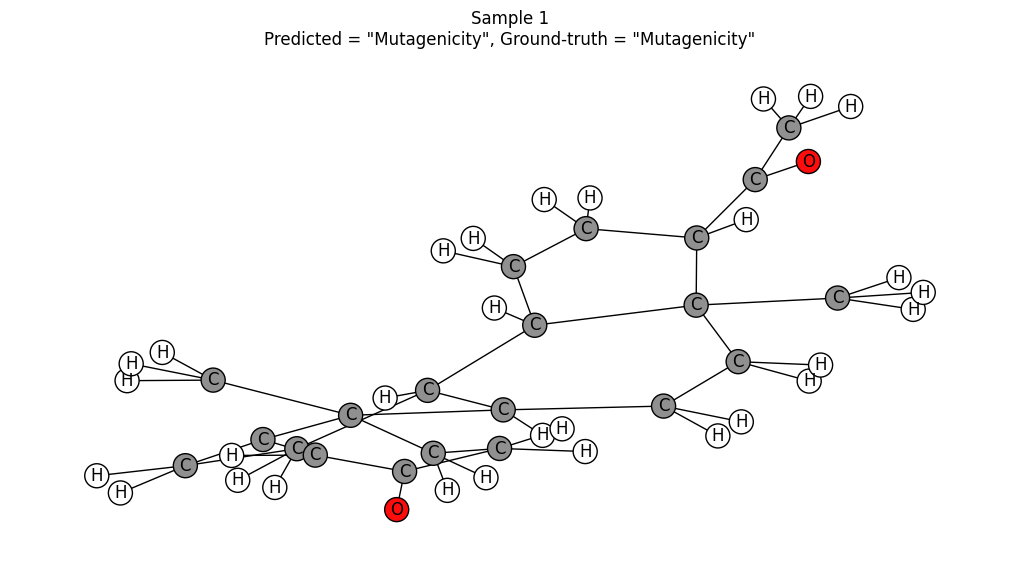

In [209]:
test_sample(1)

## Discussion
This concludes the practical on graph classification. We have focused on how to
use GNNs to classify entire graphs, where the graphs can be of arbitrary size.

We credit the Graph Classification tutorial provided by PyTorch
Geometric[[3]](#pytorchgeom) as a foundation for this practical.

# References
<a name="pytorchgeomintro"></a>
[1] https://pytorch-geometric.readthedocs.io/en/latest/index.html 

<a name="mutagenicity"></a>
[2] Kazius, J., McGuire, R., & Bursi, R. (2005). Derivation and validation of toxicophores for mutagenicity prediction. Journal of medicinal chemistry, 48(1), 312-320.

<a name="pytorchgeom"></a>
[3] https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html